# Summary of Time series analysis, decomposition:

1) Time series = trend + seasonality + irregular component (noise)
2) (Winters) exponential smoothing forecast: method to predict next time observation by weigthing previous observation in order to minimize the error. Components of trends and seasonal can be taken into account with this exponential forecast.
3) Stationarity: distribution depends only on difference on time, not location in time! need consistency of distribution to build models: expect same distribution between same among of time (01-12) vs (13-25) for example. Weak stationarity --> just mean and variance (not whole distribution) need to be the same between windows of time. Need stationarity to build stationary models. When we have seasonal data for example, we can see that in different windows of time, we don't have same mean, so no stationary. One possible when to change that: use differenciation: create new data by differencing [obs(t) - obs(t-1)] for trends adjustement. When we have seasonality, differenciate [obs[t,s] - obs[t, s-1]]: that means observation this month - observation this month previous season! Might have problem of consistency with variance also: see ARCH, GARCH models.
4) Auto-regressive (AR) models: depends on stationary: forecast series only based on previous observations (lags). AR(1) models depends on one previous observation: Yt = intercept_w + laged target_gamma(Yt-1) + e(t). Possible have AR(p) using the p previous observation (lags) to forecast series. Long memory models: even first observation might affect the series.
5) Moving average models (MA): we look at previous errors of the past: error lags. MA(1): actual Y depends on previous error of period before and actual error. (error between actual series and a forecast one). MA are short memory models, the errors of past disappear over time: effect of error have no effect on the present if happened long time ago. Also possible to get a MA(q) meaning that the series depends on q laged errors.
6) ARIMA models: Autoregressive moving average models (ARMA) have both AR and MA terms togehter in one model. How to select the number of p and q to include in the model: one possible way : automatic selection techniques (such as MINIC, SCAN, ESACF). ARIMA MODELS: Autoregressive integrated moving average models: need to put your data stationary!! ARIMA(p,d,q) meaning the number of lags, number of differenciation, and number of lagged_erros. ARIMA(1,1,1) --> diffenciation: Wt = Y(t) -Y(t-1); Wt = w + δW(t-1) + θe(t-1) + e(t).
7) ARIMA models with seasonality: remember that ARIMA needs stationarity --> we include seasonal terms! ARIMA(p,d,q)(P,D,Q)s where P represnets Seasonal AR terms, D represents Seasonal differences, Q: Seasonal MA terms, and 's' reprsents frequency of the season: how many datapoints in the season.
8) Vector autoregressive models: have multiple targets at same time using vectors. Usually using AR(p) models for vector autoregressive because computationnaly easier.
9) Evaluation: using MSE, MAE, MAPE, ... possible to use rolling (like cross-validation): use part of data for training (unitl certain date) and another small part for testing, then bring back the testing data into training to train model, and test it in new dataset that happen after in time, and so on.

# 1. Importation of libraries

In [1]:
import requests
import zipfile
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# 2. Import Data into pandas DataFrame

In [2]:
url = 'https://www.kaggle.com/api/v1/datasets/download/spingere/usa-macroeconomic-rate-of-changes-1993-2025'
filename = 'macro_monthly.csv'

if os.path.exists(filename):
    print('File exists')
else:
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(".")

File exists


In [3]:
df = pd.read_csv('macro_monthly.csv')

# 3. Data observation and cleaning

In [4]:
df.head()

,Year,Month,Industrial_Production,Manufacturers_New_Orders: Durable Goods,Consumer_Price Index,Unemployment_Rate,Retail_Sales,Producer_Price_Index,Personal_Consumption_Expenditures,National_Home_Price_Index,All_Employees(Total_Nonfarm),Labor_Force_Participation_Rate,Federal_Funds_Effective_Rate,Building_Permits,Money_Supply_(M2),Personal_Income,Trade_Balance,Consumer_Sentiment,Consumer_Confidence
0,1993,1,0.39,-3.52,0.35,-1.35,1.16,0.34,0.24,0.14,0.26,-0.15,-0.51,0.09,-0.16,-2.51,30.91,-1.87,-1.87
1,1993,2,0.48,5.93,0.21,-2.74,-0.78,0.34,0.15,0.07,0.23,0.00,0.59,-2.46,-0.13,0.61,7.10,-3.02,-3.02
2,1993,3,-0.10,-1.62,0.14,-1.41,-0.83,0.25,0.20,0.04,-0.04,0.00,0.40,-8.01,-0.08,-0.05,-88.46,-0.81,-0.81
3,1993,4,0.28,0.50,0.35,1.43,2.58,0.51,0.27,0.09,0.27,-0.15,-0.34,4.55,-0.01,1.02,4.90,-0.35,-0.35
4,1993,5,-0.37,-0.68,0.28,0.00,0.95,0.34,0.31,0.13,0.25,0.45,-0.30,0.72,0.75,0.29,32.21,-6.19,-6.19


Data are rate of changes, but FEDFUNDS rate is changes in absolute change in basis points.

In [5]:
df.shape

(384, 19)

In [6]:
df.isna().any()

Year                                       False
Month                                      False
Industrial_Production                      False
Manufacturers_New_Orders: Durable Goods    False
Consumer_Price Index                       False
Unemployment_Rate                          False
Retail_Sales                               False
Producer_Price_Index                       False
Personal_Consumption_Expenditures          False
National_Home_Price_Index                  False
All_Employees(Total_Nonfarm)               False
Labor_Force_Participation_Rate             False
Federal_Funds_Effective_Rate               False
Building_Permits                           False
Money_Supply_(M2)                          False
Personal_Income                            False
Trade_Balance                              False
Consumer_Sentiment                         False
Consumer_Confidence                        False
dtype: bool

### Transform index into datetime

In [7]:
#df['Time'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str)).dt.to_period('M')

In [8]:
df['DateTime'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

In [9]:
df = df.drop(columns=['Year', 'Month'])

In [10]:
df = df.set_index('DateTime')

In [11]:
df.head(3)

,Industrial_Production,Manufacturers_New_Orders: Durable Goods,Consumer_Price Index,Unemployment_Rate,Retail_Sales,Producer_Price_Index,Personal_Consumption_Expenditures,National_Home_Price_Index,All_Employees(Total_Nonfarm),Labor_Force_Participation_Rate,Federal_Funds_Effective_Rate,Building_Permits,Money_Supply_(M2),Personal_Income,Trade_Balance,Consumer_Sentiment,Consumer_Confidence
DateTime,,,,,,,,,,,,,,,,,
1993-01-01,0.39,-3.52,0.35,-1.35,1.16,0.34,0.24,0.14,0.26,-0.15,-0.51,0.09,-0.16,-2.51,30.91,-1.87,-1.87
1993-02-01,0.48,5.93,0.21,-2.74,-0.78,0.34,0.15,0.07,0.23,0.00,0.59,-2.46,-0.13,0.61,7.10,-3.02,-3.02
1993-03-01,-0.10,-1.62,0.14,-1.41,-0.83,0.25,0.20,0.04,-0.04,0.00,0.40,-8.01,-0.08,-0.05,-88.46,-0.81,-0.81


In [25]:
unemployment = df.groupby(df.index.year)['Unemployment_Rate'].mean()
inflation = df.groupby(df.index.year)['Consumer_Price Index'].mean()

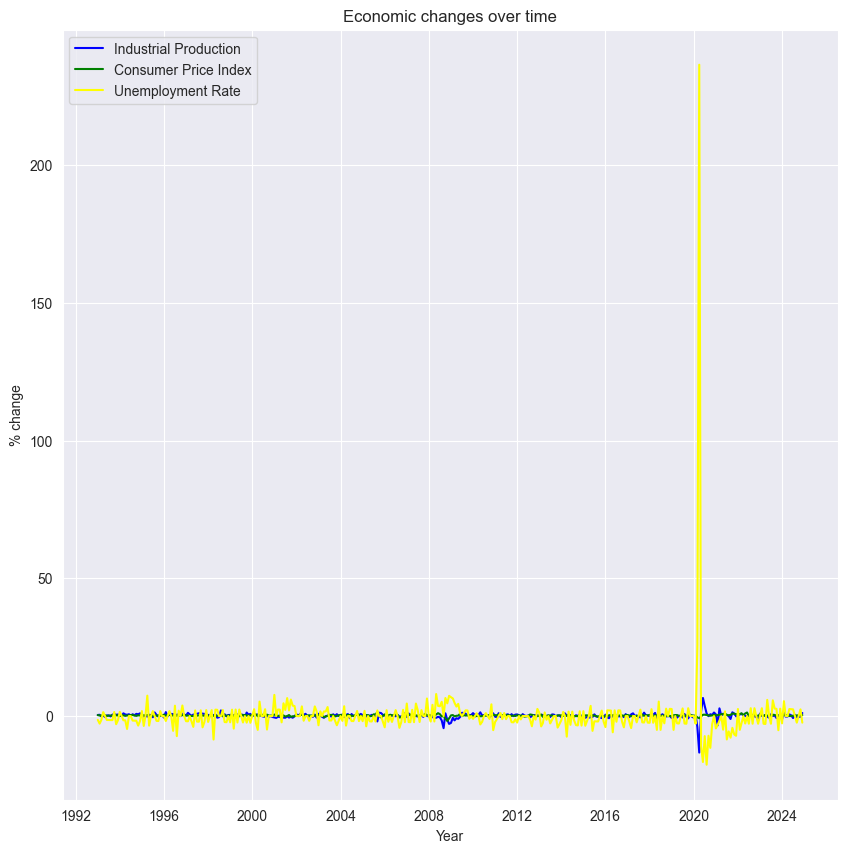

In [29]:
plt.figure(figsize = (10,10))
plt.plot(df.index, df['Industrial_Production'], color='blue', label='Industrial Production')
plt.plot(df.index, df['Consumer_Price Index'], color='green', label='Consumer Price Index')
plt.plot(df.index, df['Unemployment_Rate'], color='yellow', label='Unemployment Rate')
plt.title('Economic changes over time')
plt.xlabel('Year')
plt.ylabel('% change')
plt.legend()
plt.show()


In [33]:
m = df['Unemployment_Rate'].max()

236.36

In [44]:
k = df['Unemployment_Rate'].idxmax()
k

Timestamp('2020-04-01 00:00:00')

In [42]:
df.loc[k, 'Unemployment_Rate']


236.36

In [43]:
df['Unemployment_Rate'].mean()

0.20580729166666667